## Будникова Валерия Павловна 
### группа М8О-407Б-19
## Лабораторная работа 7

In [ ]:
import torch
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import time
import os
from pathlib import Path
import tqdm as tqdm
from torch.utils.data import DataLoader, Dataset

import onnx
import onnxruntime as ort

Загрузка данных из kaggle

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download jessicali9530/caltech256

100% 2.12G/2.12G [01:38<00:00, 23.1MB/s]
100% 2.12G/2.12G [01:38<00:00, 23.1MB/s]


In [ ]:
! unzip caltech256.zip >/dev/null

Разделение данных на тестовую и валидационную части

In [ ]:
train_lst_path = "/content/lst/train_lst.txt"
with open(train_lst_path) as file:
    train_lst = [line.rstrip() for line in file]

val_lst_path = "/content/lst/val_lst.txt"
with open(val_lst_path) as file:
    val_lst = [line.rstrip() for line in file]

In [ ]:
print(train_lst[0])

256_ObjectCategories/112.human-skeleton/112_0009.jpg 111 human-skeleton


In [ ]:
!mkdir data
!mkdir data/train
!mkdir data/val

In [ ]:
import shutil
import os
from pathlib import Path

train_path = "/content/data/train"
for train in train_lst:
  path, n, name = train.split()
  folder, cls, file = path.split("/")

  class_path = os.path.join(train_path, name)
  Path(class_path).mkdir(parents=True, exist_ok=True)
  shutil.copy("/content/"+path, os.path.join(class_path, file))


val_path = "/content/data/val"
for val in val_lst:
  path, n, name = val.split()
  folder, cls, file = path.split("/")

  class_path = os.path.join(val_path, name)
  Path(class_path).mkdir(parents=True, exist_ok=True)
  shutil.copy("/content/"+path, os.path.join(class_path, file))

Аугментация данных

In [ ]:
import os

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1)), 
        transforms.RandomRotation(45),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(), 
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.RandomErasing(0.1),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),
    'val': transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),      
    'train2': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1)), 
        transforms.RandomRotation(45),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(), 
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.RandomErasing(0.1),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),      
    'train3': transforms.Compose([
        transforms.RandomResizedCrop(224, scale=(0.5, 1)), 
        transforms.RandomRotation(45),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(), 
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.RandomErasing(0.1),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
    ]),      
}

dataset = {x: datasets.ImageFolder(os.path.join('/content/data/', x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

class_names = dataset['train'].classes

Информация о данных

In [ ]:
bs = 64
data_train = torch.utils.data.DataLoader(dataset["train"], batch_size=bs)
data_val = torch.utils.data.DataLoader(dataset["val"], batch_size=bs)

print(f"dataset['train'] size: {len(dataset['train'])}, data_train size: {len(data_train)} ")
print(f"dataset['val'] size: {len(dataset['val'])}, data_val size: {len(data_val)} ")
print(f"batch size: {bs}")
print(f"classes: ", class_names)

dataset['train'] size: 18056, data_train size: 283 
dataset['val'] size: 5862, data_val size: 92 
batch size: 64
classes:  ['airplanes-101', 'ak47', 'american-flag', 'backpack', 'baseball-bat', 'baseball-glove', 'basketball-hoop', 'bat', 'bathtub', 'bear', 'beer-mug', 'billiards', 'binoculars', 'birdbath', 'blimp', 'bonsai-101', 'boom-box', 'bowling-ball', 'bowling-pin', 'boxing-glove', 'brain-101', 'breadmaker', 'buddha-101', 'bulldozer', 'butterfly', 'cactus', 'cake', 'calculator', 'camel', 'cannon', 'canoe', 'car-side-101', 'car-tire', 'cartman', 'cd', 'centipede', 'cereal-box', 'chandelier-101', 'chess-board', 'chimp', 'chopsticks', 'cockroach', 'coffee-mug', 'coffin', 'coin', 'comet', 'computer-keyboard', 'computer-monitor', 'computer-mouse', 'conch', 'cormorant', 'covered-wagon', 'cowboy-hat', 'crab-101', 'desk-globe', 'diamond-ring', 'dice', 'dog', 'dolphin-101', 'doorknob', 'drinking-straw', 'duck', 'dumb-bell', 'eiffel-tower', 'electric-guitar-101', 'elephant-101', 'elk', 'ewe

Просмотр изображений

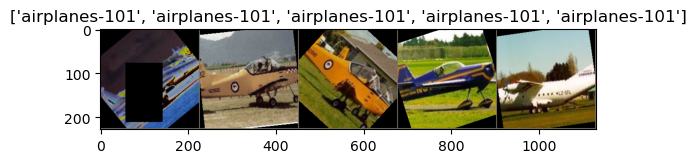

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(data_train))

n = 5
inputs = inputs[:n]
classes = classes[:n]

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Проверка на сбалансированность

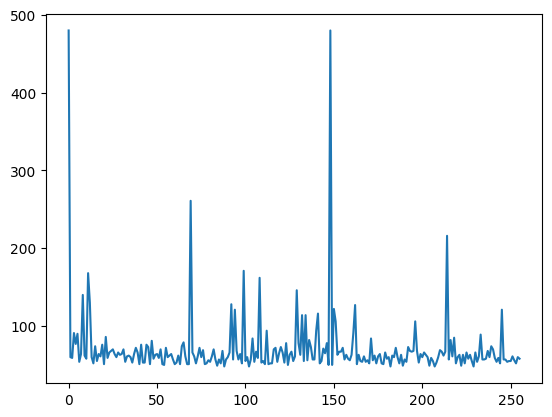

In [ ]:
count_cl = np.zeros(len(class_names))
for d, cls in data_train:
  for i in cls:
    count_cl[i] += 1

plt.plot(np.arange(0, len(count_cl)), count_cl)

Так как данные не сбалансированы, проведем undesampling

In [ ]:
! rm -rf data/train2
! rm -rf data/train3

In [ ]:
count_cl2 = np.zeros(len(count_cl))
train_path = '/content/data/train2'
train_path2 = '/content/data/train3'
for train in train_lst:
  path, n, name = train.split()
  folder, cls, file = path.split("/")
  
  ind = class_names.index(name)
  count_cl2[ind] += 1
  
  if count_cl2[ind] < 150:
    class_path = os.path.join(train_path, name)
    Path(class_path).mkdir(parents=True, exist_ok=True)
    shutil.copy("/content/"+path, os.path.join(class_path, file)) # было /content/
    
    if ind < 140:
      class_path = os.path.join(train_path2, name)
      Path(class_path).mkdir(parents=True, exist_ok=True)
      shutil.copy("/content/"+path, os.path.join(class_path, file))


In [ ]:
dataset = {x: datasets.ImageFolder(os.path.join('/content/data/', x),
                                          data_transforms[x])
                  for x in ['train2', 'val', 'train3']}

data_train = torch.utils.data.DataLoader(dataset["train2"], batch_size=bs, shuffle = True)
data_train2 = torch.utils.data.DataLoader(dataset["train3"], batch_size=bs, shuffle = True)
data_val = torch.utils.data.DataLoader(dataset["val"], batch_size=bs, shuffle = True)

Обучение модели из Pytorch

In [ ]:
from torch import optim
from torch.optim import lr_scheduler
import copy
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = models.resnet18()
model_ft = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=80)

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
num_epochs = 90

for epoch in tqdm.tqdm(range(num_epochs)):
  if best_acc > 0.6:
    break
  for phase in ['train', 'val']:
    if phase == 'train':
        model.train()
        d = data_train
    else:
        model.eval()
        d = data_val
    l_loss = []
    l_acc = []
    for inputs, labels in d:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            if phase == 'train':
                loss.backward()
                optimizer.step()

        l_loss += [loss.item()]
        l_acc += [torch.sum(preds == labels.data).item() / len(preds)]

    if phase == 'train':
        scheduler.step()

    epoch_loss = sum(l_loss) / len(l_loss)
    epoch_acc = sum(l_acc) / len(l_acc)

    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
  

model.load_state_dict(best_model_wts)

cuda:0


  0%|          | 0/90 [00:00<?, ?it/s]

train Loss: 5.7254 Acc: 0.0137


  1%|          | 1/90 [03:06<4:36:30, 186.41s/it]

val Loss: 5.2431 Acc: 0.0426
train Loss: 5.3694 Acc: 0.0258


  2%|▏         | 2/90 [06:12<4:33:24, 186.41s/it]

val Loss: 5.1915 Acc: 0.0390
train Loss: 5.2476 Acc: 0.0351


  3%|▎         | 3/90 [09:16<4:28:28, 185.15s/it]

val Loss: 4.9442 Acc: 0.0716
train Loss: 5.1307 Acc: 0.0476


  4%|▍         | 4/90 [12:23<4:26:18, 185.80s/it]

val Loss: 4.8199 Acc: 0.0860
train Loss: 5.0384 Acc: 0.0572


  6%|▌         | 5/90 [15:39<4:28:33, 189.58s/it]

val Loss: 4.7081 Acc: 0.1049
train Loss: 4.9616 Acc: 0.0650


  7%|▋         | 6/90 [21:00<5:28:08, 234.39s/it]

val Loss: 4.5877 Acc: 0.1234
train Loss: 4.9046 Acc: 0.0697


  8%|▊         | 7/90 [26:24<6:04:36, 263.58s/it]

val Loss: 4.4696 Acc: 0.1322
train Loss: 4.8495 Acc: 0.0777


  9%|▉         | 8/90 [31:38<6:22:00, 279.51s/it]

val Loss: 4.4499 Acc: 0.1397
train Loss: 4.7743 Acc: 0.0847


 10%|█         | 9/90 [36:50<6:31:16, 289.83s/it]

val Loss: 4.4127 Acc: 0.1418
train Loss: 4.7117 Acc: 0.0903


 11%|█         | 10/90 [42:10<6:38:33, 298.92s/it]

val Loss: 4.4671 Acc: 0.1355
train Loss: 4.6699 Acc: 0.0972


 12%|█▏        | 11/90 [47:56<6:52:48, 313.52s/it]

val Loss: 4.3363 Acc: 0.1502
train Loss: 4.6263 Acc: 0.1026


 13%|█▎        | 12/90 [53:50<7:03:22, 325.67s/it]

val Loss: 4.2762 Acc: 0.1616
train Loss: 4.5655 Acc: 0.1086


 14%|█▍        | 13/90 [58:44<6:45:51, 316.26s/it]

val Loss: 4.2268 Acc: 0.1688
train Loss: 4.5198 Acc: 0.1144


 16%|█▌        | 14/90 [1:03:38<6:32:05, 309.55s/it]

val Loss: 4.0721 Acc: 0.1751
train Loss: 4.4564 Acc: 0.1225


 17%|█▋        | 15/90 [1:08:23<6:17:30, 302.00s/it]

val Loss: 4.6087 Acc: 0.1437
train Loss: 4.4303 Acc: 0.1241


 18%|█▊        | 16/90 [1:13:13<6:08:13, 298.55s/it]

val Loss: 3.9965 Acc: 0.1959
train Loss: 4.3764 Acc: 0.1324


 19%|█▉        | 17/90 [1:18:07<6:01:29, 297.11s/it]

val Loss: 3.9367 Acc: 0.2079
train Loss: 4.3477 Acc: 0.1372


 20%|██        | 18/90 [1:22:53<5:52:23, 293.66s/it]

val Loss: 3.8597 Acc: 0.2098
train Loss: 4.2846 Acc: 0.1450


 21%|██        | 19/90 [1:27:51<5:48:59, 294.92s/it]

val Loss: 3.9653 Acc: 0.1975
train Loss: 4.2366 Acc: 0.1487


 22%|██▏       | 20/90 [1:32:38<5:41:33, 292.77s/it]

val Loss: 3.8054 Acc: 0.2214
train Loss: 4.2042 Acc: 0.1561


 23%|██▎       | 21/90 [1:37:31<5:36:30, 292.62s/it]

val Loss: 3.8591 Acc: 0.2107
train Loss: 4.1740 Acc: 0.1565


 24%|██▍       | 22/90 [1:42:21<5:30:43, 291.82s/it]

val Loss: 3.8585 Acc: 0.2226
train Loss: 4.0998 Acc: 0.1673


 26%|██▌       | 23/90 [1:47:04<5:23:13, 289.46s/it]

val Loss: 3.7206 Acc: 0.2430
train Loss: 4.1002 Acc: 0.1747


 27%|██▋       | 24/90 [1:51:53<5:18:09, 289.24s/it]

val Loss: 3.6385 Acc: 0.2531
train Loss: 4.0231 Acc: 0.1792


 28%|██▊       | 25/90 [1:56:49<5:15:26, 291.18s/it]

val Loss: 3.9330 Acc: 0.2113
train Loss: 3.9919 Acc: 0.1848


 29%|██▉       | 26/90 [2:01:37<5:09:34, 290.23s/it]

val Loss: 3.7589 Acc: 0.2414
train Loss: 3.9527 Acc: 0.1915


 30%|███       | 27/90 [2:06:59<5:14:40, 299.69s/it]

val Loss: 3.5573 Acc: 0.2616
train Loss: 3.9102 Acc: 0.1979


 31%|███       | 28/90 [2:16:15<6:29:14, 376.68s/it]

val Loss: 3.6107 Acc: 0.2567
train Loss: 3.8900 Acc: 0.2017


 32%|███▏      | 29/90 [2:22:29<6:22:05, 375.82s/it]

val Loss: 3.4547 Acc: 0.2796
train Loss: 3.8495 Acc: 0.2037


 33%|███▎      | 30/90 [2:25:44<5:21:35, 321.59s/it]

val Loss: 3.4794 Acc: 0.2808
train Loss: 3.8145 Acc: 0.2083


 34%|███▍      | 31/90 [2:29:10<4:42:13, 287.01s/it]

val Loss: 3.6012 Acc: 0.2567
train Loss: 3.7552 Acc: 0.2175


 36%|███▌      | 32/90 [2:32:13<4:07:10, 255.70s/it]

val Loss: 3.5079 Acc: 0.2855
train Loss: 3.7282 Acc: 0.2243


 37%|███▋      | 33/90 [2:35:16<3:42:10, 233.86s/it]

val Loss: 3.4308 Acc: 0.2844
train Loss: 3.6782 Acc: 0.2346


 38%|███▊      | 34/90 [2:38:29<3:27:01, 221.81s/it]

val Loss: 3.6227 Acc: 0.2622
train Loss: 3.6328 Acc: 0.2364


 39%|███▉      | 35/90 [2:41:43<3:15:35, 213.36s/it]

val Loss: 3.3801 Acc: 0.2929
train Loss: 3.6161 Acc: 0.2405


 40%|████      | 36/90 [2:45:01<3:07:54, 208.79s/it]

val Loss: 3.5400 Acc: 0.2892
train Loss: 3.5861 Acc: 0.2401


 41%|████      | 37/90 [2:48:20<3:01:41, 205.68s/it]

val Loss: 3.3144 Acc: 0.3124
train Loss: 3.5344 Acc: 0.2518


 42%|████▏     | 38/90 [2:51:35<2:55:37, 202.64s/it]

val Loss: 3.2333 Acc: 0.3236
train Loss: 3.5081 Acc: 0.2573


 43%|████▎     | 39/90 [2:54:54<2:51:11, 201.39s/it]

val Loss: 3.2805 Acc: 0.3223
train Loss: 3.4606 Acc: 0.2687


 44%|████▍     | 40/90 [2:58:13<2:47:13, 200.68s/it]

val Loss: 3.1695 Acc: 0.3384
train Loss: 3.4301 Acc: 0.2709


 46%|████▌     | 41/90 [3:01:42<2:46:03, 203.33s/it]

val Loss: 3.2320 Acc: 0.3287
train Loss: 3.3855 Acc: 0.2808


 47%|████▋     | 42/90 [3:05:20<2:46:13, 207.77s/it]

val Loss: 3.3385 Acc: 0.3181
train Loss: 3.3504 Acc: 0.2848


 48%|████▊     | 43/90 [3:08:30<2:38:23, 202.20s/it]

val Loss: 3.4244 Acc: 0.2985
train Loss: 3.3137 Acc: 0.2914


 49%|████▉     | 44/90 [3:11:18<2:27:12, 192.02s/it]

val Loss: 3.3328 Acc: 0.3136
train Loss: 3.2780 Acc: 0.3005


 50%|█████     | 45/90 [3:14:08<2:19:11, 185.59s/it]

val Loss: 3.1780 Acc: 0.3452
train Loss: 3.2425 Acc: 0.3028


 51%|█████     | 46/90 [3:16:54<2:11:42, 179.59s/it]

val Loss: 3.2187 Acc: 0.3412
train Loss: 3.2006 Acc: 0.3092


 52%|█████▏    | 47/90 [3:19:43<2:06:31, 176.55s/it]

val Loss: 3.1959 Acc: 0.3462
train Loss: 3.1740 Acc: 0.3137


 53%|█████▎    | 48/90 [3:22:33<2:02:08, 174.50s/it]

val Loss: 3.1163 Acc: 0.3615
train Loss: 3.1585 Acc: 0.3151


 54%|█████▍    | 49/90 [3:25:24<1:58:34, 173.52s/it]

val Loss: 3.0656 Acc: 0.3642
train Loss: 3.1066 Acc: 0.3239


 56%|█████▌    | 50/90 [3:28:19<1:55:50, 173.76s/it]

val Loss: 3.1493 Acc: 0.3625
train Loss: 3.0904 Acc: 0.3310


 57%|█████▋    | 51/90 [3:31:12<1:52:48, 173.56s/it]

val Loss: 3.1135 Acc: 0.3601
train Loss: 3.0517 Acc: 0.3345


 58%|█████▊    | 52/90 [3:34:06<1:50:05, 173.83s/it]

val Loss: 3.2559 Acc: 0.3475
train Loss: 2.9985 Acc: 0.3501


 59%|█████▉    | 53/90 [3:37:01<1:47:26, 174.23s/it]

val Loss: 3.0417 Acc: 0.3809
train Loss: 2.9828 Acc: 0.3482


 60%|██████    | 54/90 [3:39:56<1:44:32, 174.24s/it]

val Loss: 3.0759 Acc: 0.3710
train Loss: 2.9335 Acc: 0.3539


 61%|██████    | 55/90 [3:42:51<1:41:46, 174.46s/it]

val Loss: 3.0504 Acc: 0.3842
train Loss: 2.8857 Acc: 0.3687


 62%|██████▏   | 56/90 [3:45:46<1:39:00, 174.72s/it]

val Loss: 3.1467 Acc: 0.3684
train Loss: 2.8392 Acc: 0.3746


 63%|██████▎   | 57/90 [3:48:40<1:35:54, 174.38s/it]

val Loss: 3.0744 Acc: 0.3729
train Loss: 2.8498 Acc: 0.3758


 64%|██████▍   | 58/90 [3:51:34<1:32:58, 174.33s/it]

val Loss: 3.0386 Acc: 0.3878
train Loss: 2.8157 Acc: 0.3826


 66%|██████▌   | 59/90 [3:54:28<1:30:00, 174.22s/it]

val Loss: 3.0674 Acc: 0.3835
train Loss: 2.8000 Acc: 0.3859


 67%|██████▋   | 60/90 [3:57:23<1:27:13, 174.45s/it]

val Loss: 3.0085 Acc: 0.3906
train Loss: 2.7448 Acc: 0.3949


 68%|██████▊   | 61/90 [4:00:14<1:23:50, 173.46s/it]

val Loss: 3.0669 Acc: 0.3873
train Loss: 2.7018 Acc: 0.4029


 69%|██████▉   | 62/90 [4:03:04<1:20:30, 172.53s/it]

val Loss: 3.0394 Acc: 0.3925
train Loss: 2.7078 Acc: 0.4030


 70%|███████   | 63/90 [4:05:56<1:17:35, 172.41s/it]

val Loss: 3.0373 Acc: 0.3909
train Loss: 2.6655 Acc: 0.4134


 71%|███████   | 64/90 [4:08:52<1:15:05, 173.30s/it]

val Loss: 2.9849 Acc: 0.4015
train Loss: 2.6357 Acc: 0.4204


 72%|███████▏  | 65/90 [4:11:46<1:12:17, 173.51s/it]

val Loss: 2.9879 Acc: 0.4023
train Loss: 2.6045 Acc: 0.4339


 73%|███████▎  | 66/90 [4:14:41<1:09:37, 174.07s/it]

val Loss: 2.9505 Acc: 0.4057
train Loss: 2.5734 Acc: 0.4482


 74%|███████▍  | 67/90 [4:17:39<1:07:07, 175.11s/it]

val Loss: 2.9461 Acc: 0.4133
train Loss: 2.5506 Acc: 0.4561


 76%|███████▌  | 68/90 [4:21:14<1:08:36, 187.12s/it]

val Loss: 2.9804 Acc: 0.4044
train Loss: 2.5284 Acc: 0.4672


 77%|███████▋  | 69/90 [4:24:01<1:03:21, 181.05s/it]

val Loss: 2.9358 Acc: 0.4131
train Loss: 2.4984 Acc: 0.4749


 78%|███████▊  | 70/90 [4:26:50<59:12, 177.62s/it]  

val Loss: 2.9139 Acc: 0.4158
train Loss: 2.4823 Acc: 0.4829


 79%|███████▉  | 71/90 [4:29:45<56:00, 176.87s/it]

val Loss: 2.9021 Acc: 0.4203
train Loss: 2.4719 Acc: 0.4871


 80%|████████  | 72/90 [4:32:41<52:55, 176.42s/it]

val Loss: 2.8981 Acc: 0.4256
train Loss: 2.4489 Acc: 0.4901


 81%|████████  | 73/90 [4:35:36<49:55, 176.19s/it]

val Loss: 2.8852 Acc: 0.4394
train Loss: 2.4387 Acc: 0.4923


 82%|████████▏ | 74/90 [4:38:31<46:53, 175.82s/it]

val Loss: 2.8761 Acc: 0.4439
train Loss: 2.4067 Acc: 0.5001


 83%|████████▎ | 75/90 [4:41:28<43:59, 175.94s/it]

val Loss: 2.8698 Acc: 0.4589
train Loss: 2.4136 Acc: 0.5078


 84%|████████▍ | 76/90 [4:44:28<41:23, 177.40s/it]

val Loss: 2.8611 Acc: 0.4603
train Loss: 2.3989 Acc: 0.5103


 86%|████████▌ | 77/90 [4:47:19<37:58, 175.24s/it]

val Loss: 2.8503 Acc: 0.4728
train Loss: 2.3871 Acc: 0.5147


 87%|████████▋ | 78/90 [4:50:10<34:48, 174.06s/it]

val Loss: 2.8471 Acc: 0.4887
train Loss: 2.3731 Acc: 0.5237


 88%|████████▊ | 79/90 [4:53:28<33:15, 181.40s/it]

val Loss: 2.8367 Acc: 0.4956
train Loss: 2.3587 Acc: 0.5367


 89%|████████▉ | 80/90 [4:56:47<31:04, 186.42s/it]

val Loss: 2.8245 Acc: 0.5090
train Loss: 2.3513 Acc: 0.5471


 90%|█████████ | 81/90 [5:00:03<28:25, 189.51s/it]

val Loss: 2.8134 Acc: 0.5183
train Loss: 2.3501 Acc: 0.5560


 91%|█████████ | 82/90 [5:03:36<26:12, 196.52s/it]

val Loss: 2.8003 Acc: 0.5384
train Loss: 2.3398 Acc: 0.5601


 92%|█████████▏| 83/90 [5:07:12<23:35, 202.22s/it]

val Loss: 2.7998 Acc: 0.5467
train Loss: 2.3356 Acc: 0.5756


 93%|█████████▎| 84/90 [5:11:01<21:01, 210.25s/it]

val Loss: 2.7545 Acc: 0.5582
train Loss: 2.3301 Acc: 0.5831


 94%|█████████▍| 85/90 [5:15:37<19:10, 230.01s/it]

val Loss: 2.7045 Acc: 0.5621
train Loss: 2.3284 Acc: 0.5977


 96%|█████████▌| 86/90 [5:18:59<14:47, 221.78s/it]

val Loss: 2.6981 Acc: 0.5698
train Loss: 2.3246 Acc: 0.6045


 97%|█████████▋| 87/90 [5:22:38<11:02, 220.84s/it]

val Loss: 2.6827 Acc: 0.5742
train Loss: 2.3210 Acc: 0.6103


 98%|█████████▊| 88/90 [5:26:07<07:14, 217.22s/it]

val Loss: 2.6532 Acc: 0.5882
train Loss: 2.3178 Acc: 0.6251


 99%|█████████▉| 89/90 [5:29:39<03:35, 215.79s/it]

val Loss: 2.5164 Acc: 0.5901
train Loss: 2.3128 Acc: 0.6450


100%|██████████| 90/90 [5:33:32<00:00, 222.36s/it]

val Loss: 2.4322 Acc: 0.5983


ONNX формат, проверка совпадения результатов

In [ ]:
model.eval() 

# Let's create a dummy input tensor  
dummy_input = torch.randn(10, 3, 224, 224, device="cuda")  

# Export the model   
torch.onnx.export(model,                                 # model being run 
      dummy_input,                                        # model input (or a tuple for multiple inputs) 
      'resnet18.onnx',                                          # where to save the model  
      export_params=True,                                 # store the trained parameter weights inside the model file 
      opset_version=10,                                   # the ONNX version to export the model to 
      do_constant_folding=True,                           # whether to execute constant folding for optimization 
      input_names = ['modelInput'],                       # the model's input names 
      output_names = ['modelOutput'],                     # the model's output names 
      dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes 
                            'modelOutput' : {0 : 'batch_size'}}) 


In [ ]:
model_onnx = onnx.load("resnet18.onnx")
onnx.checker.check_model(model_onnx)

In [ ]:
x = torch.randn(bs, 3, 224, 224, requires_grad=True).to(device)
torch_out = model(x)

ort_session = ort.InferenceSession('resnet18.onnx')

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

Структура модели ResNet

In [ ]:
class ResnetBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResnetBlock, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=(1 + (in_channels != out_channels)), padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(out_channels)
        self.relu = torch.nn.ReLU(True)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = torch.nn.BatchNorm2d(out_channels)
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2, bias=False),
                torch.nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            x = self.downsample(x)
        return self.relu(x + out)
    
class Resnet18(torch.nn.Module):
    def __init__(self, num_classes):
        super(Resnet18, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU(True)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = torch.nn.Sequential(
            ResnetBlock(64, 64),
            ResnetBlock(64, 64)
        )
        self.layer2 = torch.nn.Sequential(
            ResnetBlock(64, 128),
            ResnetBlock(128, 128)
        )
        self.layer3 = torch.nn.Sequential(
            ResnetBlock(128, 256),
            ResnetBlock(256, 256)
        )
        self.layer4 = torch.nn.Sequential(
            ResnetBlock(256, 512),
            ResnetBlock(512, 512)
        )

        self.avgpool = torch.nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc = torch.nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        return self.fc(x.flatten(1))

Обучение модели

In [ ]:
rn = Resnet18(257)
rn = rn.to(device)

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.SGD(rn.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 75, eta_min=5e-4)
num_epochs = 75


rn.train()

for epoch in tqdm.tqdm(range(num_epochs)):
    l_loss_tr = 0
    l_acc_tr = 0
    for inputs, labels in data_train:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        p = np.random.rand()
        if p < 0.2:
            if np.random.rand() < 0.5:
                inds = torch.randperm(inputs.size(0))
                inputs = inputs * np.random.beta(0.2, 0.2) + inputs[inds] * (1 - np.random.beta(0.2, 0.2))
                labels = [labels, labels[inds], np.random.beta(0.2, 0.2)]

            else:
                inds = torch.randperm(inputs.size(0))
                ind1 = np.clip(np.random.randint(inputs.size()[2]) - int(inputs.size()[2] * np.sqrt(1. - np.random.beta(1, 1))) // 2, 0, inputs.size()[2])
                ind2 = np.clip(np.random.randint(inputs.size()[3]) - int(inputs.size()[3] * np.sqrt(1. - np.random.beta(1, 1))) // 2, 0, inputs.size()[3])
                ind3 = np.clip(np.random.randint(inputs.size()[2]) + int(inputs.size()[2] * np.sqrt(1. - np.random.beta(1, 1))) // 2, 0, inputs.size()[2])
                ind4 = np.clip(np.random.randint(inputs.size()[3]) + int(inputs.size()[3] * np.sqrt(1. - np.random.beta(1, 1))) // 2, 0, inputs.size()[3])
                inputs[:, :, ind1:ind3, ind2:ind4] = inputs[inds, :, ind1:ind3, ind2:ind4]
                labels = [labels, labels[inds], 1 - ((ind3 - ind1) * (ind4 - ind2) / (inputs.size()[-1] * inputs.size()[-2]))]

        output = rn(inputs)
        _, pred = torch.max(output, 1)
        if p < 0.2:
            loss =  labels[2] * criterion(output, labels[0]) + (1 - labels[2]) * criterion(output, labels[1])
        else:
            loss = criterion(output, labels)
        
        loss.backward()
        
        optimizer.step()
        l_loss_tr += loss.item() * len(inputs) / len(data_train)
        if p < 0.2:
            l_acc_tr += (labels[2] * (pred == labels[0]).sum() + (1 - labels[2]) * (pred == labels[1]).sum()).item()
        else:
            l_acc_tr += torch.sum(labels == pred).item()

    train_loss = l_loss_tr
    train_acc = l_acc_tr / len(data_train)

    if scheduler is not None:
        scheduler.step()
    
    rn.eval()
    l_loss_vl = 0
    l_acc_vl = 0
    with torch.no_grad():
        for inputs, labels in data_val:
            inputs = inputs.to(device)
            labels = labels.to(device)

            output = rn(inputs)
            _, pred = torch.max(output, 1)
            loss = criterion(output, labels)

            l_loss_vl += loss.item() * len(inputs) / len(data_val)
            l_acc_vl += torch.sum(labels == pred).item()

    val_loss = l_loss_vl
    val_acc = l_acc_vl / len(data_val)
    print(f"Train Loss: {train_loss:.4f} Acc: {val_loss:.4f}")
    print(f"Val Loss: {train_loss:.4f} Acc: {val_loss:.4f}")
    
    rn.train()
    with torch.no_grad():
        torch.cuda.empty_cache()

  1%|▏         | 1/75 [01:26<1:46:06, 86.03s/it]

Train Loss: 5.5323 Acc: 0.0104
Val Loss: 5.3806 Acc: 0.0193


  3%|▎         | 2/75 [02:48<1:42:01, 83.85s/it]

Train Loss: 5.3387 Acc: 0.0217
Val Loss: 5.1548 Acc: 0.0430


  4%|▍         | 3/75 [04:13<1:41:26, 84.53s/it]

Train Loss: 5.2285 Acc: 0.0335
Val Loss: 5.2182 Acc: 0.0357


  5%|▌         | 4/75 [05:36<1:39:16, 83.89s/it]

Train Loss: 5.1198 Acc: 0.0444
Val Loss: 5.0047 Acc: 0.0662


  7%|▋         | 5/75 [07:00<1:38:04, 84.06s/it]

Train Loss: 5.0210 Acc: 0.0575
Val Loss: 5.0206 Acc: 0.0699


  8%|▊         | 6/75 [08:23<1:36:13, 83.67s/it]

Train Loss: 4.9331 Acc: 0.0716
Val Loss: 4.7420 Acc: 0.1053


  9%|▉         | 7/75 [09:46<1:34:24, 83.30s/it]

Train Loss: 4.8240 Acc: 0.0863
Val Loss: 4.7978 Acc: 0.1177


 11%|█         | 8/75 [11:13<1:34:25, 84.56s/it]

Train Loss: 4.7363 Acc: 0.1000
Val Loss: 4.4149 Acc: 0.1576


 12%|█▏        | 9/75 [12:40<1:33:43, 85.20s/it]

Train Loss: 4.6620 Acc: 0.1148
Val Loss: 4.2923 Acc: 0.1931


 13%|█▎        | 10/75 [14:05<1:32:26, 85.33s/it]

Train Loss: 4.5761 Acc: 0.1285
Val Loss: 4.2028 Acc: 0.2015


 15%|█▍        | 11/75 [15:31<1:31:06, 85.41s/it]

Train Loss: 4.4481 Acc: 0.1450
Val Loss: 4.1473 Acc: 0.2177


 16%|█▌        | 12/75 [16:56<1:29:39, 85.39s/it]

Train Loss: 4.3835 Acc: 0.1614
Val Loss: 4.0056 Acc: 0.2460


 17%|█▋        | 13/75 [18:22<1:28:17, 85.45s/it]

Train Loss: 4.2926 Acc: 0.1779
Val Loss: 3.8884 Acc: 0.2694


 19%|█▊        | 14/75 [19:45<1:25:59, 84.58s/it]

Train Loss: 4.1750 Acc: 0.2016
Val Loss: 3.9919 Acc: 0.2537


 20%|█▉        | 15/75 [21:09<1:24:38, 84.63s/it]

Train Loss: 4.0577 Acc: 0.2206
Val Loss: 3.8287 Acc: 0.2885


 21%|██        | 16/75 [22:34<1:23:16, 84.69s/it]

Train Loss: 3.9858 Acc: 0.2362
Val Loss: 3.8828 Acc: 0.2641


 23%|██▏       | 17/75 [23:53<1:20:17, 83.06s/it]

Train Loss: 3.9023 Acc: 0.2595
Val Loss: 3.7143 Acc: 0.3050


 24%|██▎       | 18/75 [25:12<1:17:46, 81.88s/it]

Train Loss: 3.7760 Acc: 0.2766
Val Loss: 3.6209 Acc: 0.3190


 25%|██▍       | 19/75 [26:34<1:16:14, 81.69s/it]

Train Loss: 3.7466 Acc: 0.2894
Val Loss: 3.6141 Acc: 0.3224


 27%|██▌       | 20/75 [28:00<1:16:10, 83.10s/it]

Train Loss: 3.6398 Acc: 0.3160
Val Loss: 3.5889 Acc: 0.3454


 28%|██▋       | 21/75 [29:26<1:15:25, 83.80s/it]

Train Loss: 3.6029 Acc: 0.3255
Val Loss: 3.4019 Acc: 0.3826


 29%|██▊       | 22/75 [30:51<1:14:20, 84.17s/it]

Train Loss: 3.5397 Acc: 0.3422
Val Loss: 3.5941 Acc: 0.3378


 31%|███       | 23/75 [32:16<1:13:19, 84.60s/it]

Train Loss: 3.4948 Acc: 0.3487
Val Loss: 3.3483 Acc: 0.3944


 32%|███▏      | 24/75 [33:39<1:11:20, 83.94s/it]

Train Loss: 3.3116 Acc: 0.3897
Val Loss: 3.2767 Acc: 0.4110


 33%|███▎      | 25/75 [34:57<1:08:34, 82.30s/it]

Train Loss: 3.2642 Acc: 0.4002
Val Loss: 3.2631 Acc: 0.4110


 35%|███▍      | 26/75 [36:16<1:06:20, 81.24s/it]

Train Loss: 3.2613 Acc: 0.3986
Val Loss: 3.3356 Acc: 0.4031


 36%|███▌      | 27/75 [37:37<1:04:59, 81.24s/it]

Train Loss: 3.1602 Acc: 0.4254
Val Loss: 3.2475 Acc: 0.4229


 37%|███▋      | 28/75 [38:58<1:03:30, 81.08s/it]

Train Loss: 3.0942 Acc: 0.4459
Val Loss: 3.1515 Acc: 0.4408


 39%|███▊      | 29/75 [40:19<1:02:08, 81.05s/it]

Train Loss: 3.0378 Acc: 0.4622
Val Loss: 3.4608 Acc: 0.3779


 40%|███▉      | 30/75 [41:38<1:00:21, 80.47s/it]

Train Loss: 3.0467 Acc: 0.4584
Val Loss: 3.1222 Acc: 0.4645


 41%|████      | 31/75 [43:01<59:35, 81.26s/it]  

Train Loss: 2.9701 Acc: 0.4818
Val Loss: 3.0622 Acc: 0.4594


 43%|████      | 32/75 [44:28<59:31, 83.06s/it]

Train Loss: 2.9606 Acc: 0.4887
Val Loss: 3.0459 Acc: 0.4684


 44%|████▏     | 33/75 [45:52<58:11, 83.13s/it]

Train Loss: 2.9097 Acc: 0.4992
Val Loss: 3.0558 Acc: 0.4724


 45%|████▍     | 34/75 [47:10<55:48, 81.67s/it]

Train Loss: 2.8620 Acc: 0.5087
Val Loss: 3.0158 Acc: 0.4852


 47%|████▌     | 35/75 [48:28<53:40, 80.52s/it]

Train Loss: 2.7361 Acc: 0.5372
Val Loss: 3.0407 Acc: 0.4858


 48%|████▋     | 36/75 [49:45<51:46, 79.67s/it]

Train Loss: 2.7393 Acc: 0.5424
Val Loss: 2.9682 Acc: 0.5002


 49%|████▉     | 37/75 [51:03<50:08, 79.18s/it]

Train Loss: 2.6196 Acc: 0.5693
Val Loss: 3.0204 Acc: 0.4800


 51%|█████     | 38/75 [52:24<49:08, 79.70s/it]

Train Loss: 2.6296 Acc: 0.5713
Val Loss: 2.8791 Acc: 0.5189


 52%|█████     | 39/75 [53:46<48:13, 80.39s/it]

Train Loss: 2.5765 Acc: 0.5796
Val Loss: 2.9788 Acc: 0.4957


 53%|█████▎    | 40/75 [55:12<47:47, 81.93s/it]

Train Loss: 2.5672 Acc: 0.5927
Val Loss: 2.8887 Acc: 0.5164


 55%|█████▍    | 41/75 [56:38<47:07, 83.16s/it]

Train Loss: 2.4810 Acc: 0.6156
Val Loss: 2.9536 Acc: 0.5084


 56%|█████▌    | 42/75 [58:02<45:52, 83.42s/it]

Train Loss: 2.4621 Acc: 0.6208
Val Loss: 2.9257 Acc: 0.5206


 57%|█████▊    | 43/75 [59:26<44:40, 83.75s/it]

Train Loss: 2.4402 Acc: 0.6224
Val Loss: 2.8573 Acc: 0.5334


 59%|█████▉    | 44/75 [1:00:52<43:30, 84.20s/it]

Train Loss: 2.3765 Acc: 0.6402
Val Loss: 2.8130 Acc: 0.5415


 60%|██████    | 45/75 [1:02:17<42:19, 84.64s/it]

Train Loss: 2.3675 Acc: 0.6474
Val Loss: 2.8504 Acc: 0.5254


 61%|██████    | 46/75 [1:03:44<41:08, 85.13s/it]

Train Loss: 2.2875 Acc: 0.6659
Val Loss: 2.7814 Acc: 0.5421


 63%|██████▏   | 47/75 [1:05:05<39:11, 83.99s/it]

Train Loss: 2.2742 Acc: 0.6774
Val Loss: 2.8241 Acc: 0.5415


 64%|██████▎   | 48/75 [1:06:25<37:17, 82.88s/it]

Train Loss: 2.1802 Acc: 0.7026
Val Loss: 2.8179 Acc: 0.5437


 65%|██████▌   | 49/75 [1:07:45<35:32, 82.03s/it]

Train Loss: 2.3208 Acc: 0.6700
Val Loss: 2.7502 Acc: 0.5527


 67%|██████▋   | 50/75 [1:09:05<33:53, 81.35s/it]

Train Loss: 2.1892 Acc: 0.6998
Val Loss: 2.7258 Acc: 0.5635


 68%|██████▊   | 51/75 [1:10:23<32:07, 80.32s/it]

Train Loss: 2.1573 Acc: 0.7120
Val Loss: 2.6879 Acc: 0.5672


 69%|███████   | 52/75 [1:11:39<30:20, 79.17s/it]

Train Loss: 2.1783 Acc: 0.7049
Val Loss: 2.7458 Acc: 0.5527


 71%|███████   | 53/75 [1:12:56<28:45, 78.41s/it]

Train Loss: 2.1434 Acc: 0.7239
Val Loss: 2.6736 Acc: 0.5711


 72%|███████▏  | 54/75 [1:14:13<27:16, 77.92s/it]

Train Loss: 2.0699 Acc: 0.7400
Val Loss: 2.6464 Acc: 0.5745


 73%|███████▎  | 55/75 [1:15:33<26:12, 78.64s/it]

Train Loss: 1.9880 Acc: 0.7584
Val Loss: 2.6806 Acc: 0.5679


 75%|███████▍  | 56/75 [1:16:53<25:02, 79.08s/it]

Train Loss: 1.9910 Acc: 0.7623
Val Loss: 2.6196 Acc: 0.5819


 76%|███████▌  | 57/75 [1:18:15<23:57, 79.86s/it]

Train Loss: 2.0116 Acc: 0.7586
Val Loss: 2.6147 Acc: 0.5882


 77%|███████▋  | 58/75 [1:19:37<22:47, 80.47s/it]

Train Loss: 1.9556 Acc: 0.7716
Val Loss: 2.6249 Acc: 0.5785


 79%|███████▊  | 59/75 [1:20:57<21:26, 80.39s/it]

Train Loss: 1.9165 Acc: 0.7822
Val Loss: 2.6055 Acc: 0.5861


 80%|████████  | 60/75 [1:22:17<20:06, 80.41s/it]

Train Loss: 1.9798 Acc: 0.7738
Val Loss: 2.5929 Acc: 0.5901


 81%|████████▏ | 61/75 [1:23:38<18:46, 80.46s/it]

Train Loss: 1.9274 Acc: 0.7851
Val Loss: 2.5548 Acc: 0.5969


 83%|████████▎ | 62/75 [1:24:58<17:25, 80.44s/it]

Train Loss: 1.8351 Acc: 0.8075
Val Loss: 2.5322 Acc: 0.5993


 84%|████████▍ | 63/75 [1:26:19<16:05, 80.47s/it]

Train Loss: 1.8191 Acc: 0.8089
Val Loss: 2.5460 Acc: 0.5979


 85%|████████▌ | 64/75 [1:27:39<14:45, 80.46s/it]

Train Loss: 1.8299 Acc: 0.8031
Val Loss: 2.5418 Acc: 0.5952


 87%|████████▋ | 65/75 [1:29:01<13:28, 80.84s/it]

Train Loss: 1.8613 Acc: 0.8023
Val Loss: 2.5371 Acc: 0.5989


 88%|████████▊ | 66/75 [1:30:37<12:48, 85.39s/it]

Train Loss: 1.8159 Acc: 0.8116
Val Loss: 2.5277 Acc: 0.6058


 89%|████████▉ | 67/75 [1:31:57<11:10, 83.85s/it]

Train Loss: 1.7984 Acc: 0.8181
Val Loss: 2.5320 Acc: 0.6003


 91%|█████████ | 68/75 [1:33:18<09:39, 82.85s/it]

Train Loss: 1.8472 Acc: 0.8079
Val Loss: 2.5191 Acc: 0.6034


 92%|█████████▏| 69/75 [1:34:39<08:13, 82.19s/it]

Train Loss: 1.7737 Acc: 0.8224
Val Loss: 2.5096 Acc: 0.6109


 93%|█████████▎| 70/75 [1:35:59<06:48, 81.69s/it]

Train Loss: 1.7544 Acc: 0.8301
Val Loss: 2.5185 Acc: 0.6082


 95%|█████████▍| 71/75 [1:37:22<05:27, 81.98s/it]

Train Loss: 1.6929 Acc: 0.8423
Val Loss: 2.5016 Acc: 0.6163


 96%|█████████▋| 72/75 [1:38:42<04:04, 81.45s/it]

Train Loss: 1.7405 Acc: 0.8337
Val Loss: 2.5013 Acc: 0.6126


 97%|█████████▋| 73/75 [1:40:02<02:42, 81.16s/it]

Train Loss: 1.7324 Acc: 0.8359
Val Loss: 2.5044 Acc: 0.6131


 99%|█████████▉| 74/75 [1:41:23<01:21, 81.11s/it]

Train Loss: 1.7312 Acc: 0.8347
Val Loss: 2.4919 Acc: 0.6146


100%|██████████| 75/75 [1:42:44<00:00, 82.19s/it]

Train Loss: 1.7335 Acc: 0.8348
Val Loss: 2.4974 Acc: 0.6109


ONNX формат, проверка совпадения результатов

In [ ]:
rn.eval() 

# Let's create a dummy input tensor  
dummy_input = torch.randn(10, 3, 224, 224, device="cuda")  

# Export the model   
torch.onnx.export(rn,                                 # model being run 
      dummy_input,                                        # model input (or a tuple for multiple inputs) 
      '__resnet18.onnx',                                          # where to save the model  
      export_params=True,                                 # store the trained parameter weights inside the model file 
      opset_version=10,                                   # the ONNX version to export the model to 
      do_constant_folding=True,                           # whether to execute constant folding for optimization 
      input_names = ['modelInput'],                       # the model's input names 
      output_names = ['modelOutput'],                     # the model's output names 
      dynamic_axes={'modelInput' : {0 : 'batch_size'},    # variable length axes 
                            'modelOutput' : {0 : 'batch_size'}}) 


In [ ]:
model_onnx = onnx.load("__resnet18.onnx")
onnx.checker.check_model(model_onnx)

In [ ]:
x = torch.randn(bs, 3, 224, 224, requires_grad=True).to(device)
torch_out = rn(x)

ort_session = ort.InferenceSession('__resnet18.onnx')

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)